In [7]:
import pandas as pd
# from langdetect import detect
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import cohen_kappa_score
import seaborn as sns
import re
import torch
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,precision_recall_fscore_support,ConfusionMatrixDisplay

import seaborn as sns
import matplotlib.pyplot as plt
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from transformers import AutoModel
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import torch
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)
from datasets import Dataset
import numpy as np
import evaluate
from sklearn.utils.class_weight import compute_class_weight


In [8]:
ldf = pd.read_csv("../week5/week5_qbias_dataset.csv")
ldf.dropna(subset=['raw'], inplace=True)
ldf = ldf[ldf['raw'].str.len() > 0]
# !ls

In [8]:
ldf.head()

,raw,bias_rating,clean,label_right,label_left,label_center
0,[HEADLINE]Chicago Gun Violence Spikes and Incr...,left,[headline]chicago gun violence spikes and incr...,0,1,0
1,[HEADLINE]‘Bullets just came from nowhere’: Fo...,center,[headline]‘bullets just came from nowhere’: fo...,0,0,1
2,[HEADLINE]Dozens of shootings across US mark b...,right,[headline]dozens of shootings across us mark b...,1,0,0
3,[HEADLINE]Federal Government Will Run Out of C...,right,[headline]federal government will run out of c...,1,0,0
4,[HEADLINE]Yellen tells Congress that U.S. will...,left,[headline]yellen tells congress that u.s. will...,0,1,0


In [9]:
label_encoder = LabelEncoder()
ldf["class_id"] = label_encoder.fit_transform(ldf["bias_rating"])
labels = torch.tensor(ldf["class_id"].values, dtype=torch.long)

label_mapping = {idx: label for idx, label in enumerate(label_encoder.classes_)}
num_classes = len(label_mapping)

# train_labels = ldf['code']

# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(train_labels),
#     y=train_labels
# )

# class_weights = torch.tensor(class_weights, dtype=torch.float)


In [11]:
# tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0", device_map="auto")
model = AutoModelForSequenceClassification.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0", 
                                                           num_labels=num_classes, torch_dtype="auto")

ldf_ds = ldf[['raw', 'bias_rating', 'class_id']]
dataset = Dataset.from_pandas(ldf_ds)
max_query_length = int(ldf['raw'].str.len().max())

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def preprocess(example):

    tokenized = tokenizer(
        example["raw"], 
        padding="max_length", 
        truncation=True, 
        max_length=max_query_length
    )
    return {
        "input_ids": tokenized["input_ids"],
        "attention_mask": tokenized["attention_mask"],  # Include attention mask
        "labels": example["class_id"],  # Define class_id as labels
    }

dataset = dataset.map(preprocess, batched=True)
# dataset = dataset.train_test_split(test_size=0.2, seed=42)


# def tokenize_function(examples):
#     return tokenizer(examples["text"], padding="max_length", truncation=True)


# tokenized_datasets = dataset.map(tokenize_function, batched=True)
# tokenized_dataset = dataset.map(lambda x: tokenizer(x["user_query"], truncation=True, padding=True), batched=True)


small_train_dataset = dataset["train"].shuffle(seed=42)  #.select(range(1000))
small_eval_dataset = dataset["test"].shuffle(seed=42)  #.sample(1000)

# small_train_dataset = dataset
# small_eval_dataset = dataset

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 21747/21747 [00:06<00:00, 3332.45 examples/s]


KeyError: "Column train not in the dataset. Current columns in the dataset: ['raw', 'bias_rating', 'class_id', '__index_level_0__', 'input_ids', 'attention_mask', 'labels']"

In [7]:
torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=None, abbreviated=False))


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   5938 MiB |   9887 MiB |  14641 GiB |  14636 GiB |
|       from large pool |   5806 MiB |   9666 MiB |  14301 GiB |  14295 GiB |
|       from small pool |    132 MiB |    220 MiB |    340 GiB |    340 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   5938 MiB |   9887 MiB |  14641 GiB |  14636 GiB |
|       from large pool |   5806 MiB |   9666 MiB |  14301 GiB |

In [5]:
model.config.pad_token_id = tokenizer.pad_token_id


# Training arguments
training_args = TrainingArguments(
    output_dir="./pytorch_HF_satWeek6",
    evaluation_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    # fp16=torch.cuda.is_available(),
    # logging_steps=10,
    # bf16= not torch.cuda.is_available(),
    # fp16 = False,
    bf16 = True,
    # optim="adamw_fp16",
    # gradient_accumulation_steps=4,
)
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
)


# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(f"Accuracy: {results['eval_accuracy']:.4f}")

# Save the trained model
trainer.save_model("trained_model")


/ihome/xli/sek188/.local/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/scratch/slurm-1100325/ipykernel_64422/1948411664.py:28: FutureWarning: `tokenizer` is deprecated and will be r

Epoch,Training Loss,Validation Loss,Accuracy
1,0.711300,0.697133,0.709655
2,0.575900,1.448552,0.708276
3,0.245100,2.251924,0.699310
4,0.116600,2.382524,0.698621
5,0.067700,2.381966,0.693333


Accuracy: 0.6933


Classification Report:
              precision    recall  f1-score   support

      center       0.61      0.58      0.59       860
        left       0.74      0.77      0.75      2043
       right       0.68      0.66      0.67      1447

    accuracy                           0.69      4350
   macro avg       0.68      0.67      0.67      4350
weighted avg       0.69      0.69      0.69      4350

Accuracy: 0.6943


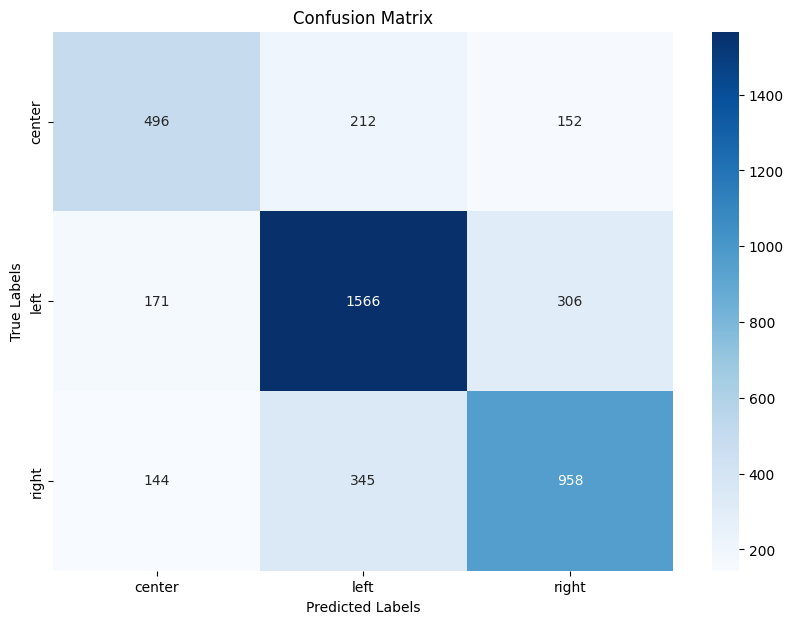

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (6).

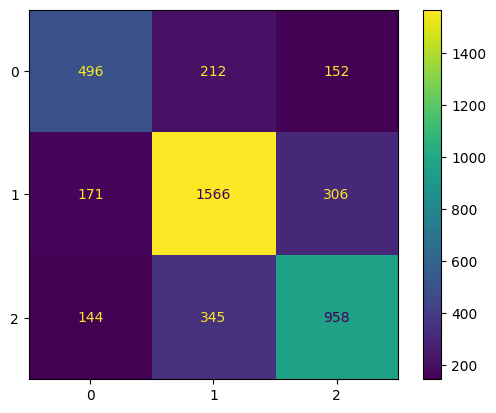

In [13]:

model = AutoModelForSequenceClassification.from_pretrained("trained_model")
tokenizer = AutoTokenizer.from_pretrained("trained_model")

# Move model to the appropriate device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

dataset = dataset.train_test_split(test_size=0.2, seed=42)

# Set model to evaluation mode
model.eval()

def custom_collate_fn(batch):
    input_ids = torch.stack([torch.tensor(item["input_ids"]) for item in batch])
    attention_mask = torch.stack([torch.tensor(item["attention_mask"]) for item in batch])
    labels = torch.tensor([item["class_id"] for item in batch], dtype=torch.long)

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "label": labels
    }

dataloader = DataLoader(dataset["test"], batch_size=8, shuffle=False, collate_fn=custom_collate_fn)



# collate_fn = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

# dataloader = DataLoader(dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)


model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"

true_labels = []
pred_labels = []



with torch.no_grad():
    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].cpu().numpy()  # Ground truth labels

        outputs = model(input_ids, attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1).cpu().numpy()

        true_labels.extend(labels)
        pred_labels.extend(predictions)

# Convert class IDs back to labels
true_labels = label_encoder.inverse_transform(true_labels)
pred_labels = label_encoder.inverse_transform(pred_labels)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, pred_labels))

# Calculate accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average="weighted")
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
# print(cm)
# print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
# print(dataset[0])
